<a href="https://colab.research.google.com/github/kelaxax/ML/blob/main/%22%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Копирование данных: Создадим копию исходного датасета df_not_processed, которую будем использовать для анализа и интерпретации кластеров после их формирования.

Обработка категориальных признаков: Преобразуем категориальные столбцы в числовой формат с помощью One-Hot Encoding.

Масштабирование (нормализация): Приведем все числовые признаки к единому масштабу (от 0 до 1) с помощью MinMaxScaler. Это необходимо, так как алгоритмы кластеризации, основанные на расстоянии (как K-Means и DBSCAN), чувствительны к масштабу признаков.

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Загрузка данных
df = pd.read_csv('/content/Coffe_sales.csv')

# Создаем копию датафрейма для последующего анализа (до преобразований)
df_not_processed = df.copy()

# 1. Определяем категориальные и числовые признаки
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
# Исключим столбцы, которые не несут прямой информации для кластеризации
# (например, Дата и Время)
categorical_features_to_encode = ['cash_type', 'Time_of_Day', 'Weekday', 'Month_name']
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 2. Применяем One-Hot Encoding к категориальным признакам
# drop_first=True, чтобы избежать мультиколлинеарности
df_encoded = pd.get_dummies(df, columns=categorical_features_to_encode, drop_first=True, dtype=float)

# 3. Масштабируем все числовые признаки
# Обновим список числовых признаков, так как get_dummies добавила новые
numeric_features_for_scaling = df_encoded.select_dtypes(include=['int64', 'float64']).columns

scaler = MinMaxScaler()
df_scaled = df_encoded.copy()
df_scaled[numeric_features_for_scaling] = scaler.fit_transform(df_encoded[numeric_features_for_scaling])

# Удалим исходные текстовые колонки, которые больше не нужны для модели
df_processed = df_scaled.drop(columns=['coffee_name', 'Date', 'Time'])

print("Данные успешно подготовлены.")
print("Размерность обработанного датасета:", df_processed.shape)
print("\nПервые 5 строк обработанных данных:")
df_processed.head()

Данные успешно подготовлены.
Размерность обработанного датасета: (3547, 23)

Первые 5 строк обработанных данных:


,hour_of_day,money,Weekdaysort,Monthsort,Time_of_Day_Morning,Time_of_Day_Night,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,...,Month_name_Dec,Month_name_Feb,Month_name_Jan,Month_name_Jul,Month_name_Jun,Month_name_Mar,Month_name_May,Month_name_Nov,Month_name_Oct,Month_name_Sep
0,0.2500,1.00000,0.666667,0.181818,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.3750,1.00000,0.666667,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.3750,1.00000,0.666667,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.4375,0.52381,0.666667,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.4375,1.00000,0.666667,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Теперь применим алгоритм K-Means. Этот метод делит данные на k заранее заданных кластеров. Алгоритм итеративно находит центры кластеров и относит каждую точку данных к ближайшему центру.

Для начала выберем количество кластеров, равное 8 (по числу видов кофе), и посмотрим, сможет ли алгоритм самостоятельно сгруппировать данные похожим образом.

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Задаем количество кластеров
n_clusters_kmeans = 8

# Инициализируем и обучаем модель K-Means
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(df_processed)

# Добавляем результаты кластеризации в наш "чистый" датасет для анализа
df_not_processed['k_means_cluster'] = clusters_kmeans

# Выводим статистику по кластерам
print(f"Статистика по {n_clusters_kmeans} кластерам (K-Means):")
cluster_analysis_kmeans = df_not_processed.groupby('k_means_cluster')[['money', 'hour_of_day']].mean().round(2)
# Добавим размер кластера для понимания
cluster_analysis_kmeans['size'] = df_not_processed['k_means_cluster'].value_counts()
print(cluster_analysis_kmeans)

# Расчет метрик качества кластеризации
silhouette_kmeans = silhouette_score(df_processed, clusters_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(df_processed, clusters_kmeans)
calinski_harabasz_kmeans = calinski_harabasz_score(df_processed, clusters_kmeans)

print("\n=== Метрики качества для K-Means ===")
print(f"Silhouette Score: {silhouette_kmeans:.4f} (чем ближе к 1, тем лучше)")#насколько хорошо каждая точка принадлежит своему кластеру
                                                                              #и насколько далеко она от соседнего кластера
print(f"Davies-Bouldin Index: {davies_bouldin_kmeans:.4f} (чем ближе к 0, тем лучше)")#измеряет, насколько “похожи” кластеры между собой,
                                                                                      #учитывая их плотность и расстояния между центрами
print(f"Calinski-Harabasz Index: {calinski_harabasz_kmeans:.4f} (чем больше, тем лучше)")#сравнивает разброс между кластерами и внутри них.
                                                                                        #Показывает, насколько кластеры плотные и отделённые

Статистика по 8 кластерам (K-Means):
                 money  hour_of_day  size
k_means_cluster                          
0                31.92        14.01   544
1                32.76        19.24   417
2                32.03        13.93   534
3                30.08         9.44   616
4                33.23        19.18   205
5                31.50        14.23   500
6                32.07        16.89   364
7                30.94        11.52   367

=== Метрики качества для K-Means ===
Silhouette Score: 0.1590 (чем ближе к 1, тем лучше)
Davies-Bouldin Index: 1.9657 (чем ближе к 0, тем лучше)
Calinski-Harabasz Index: 323.6507 (чем больше, тем лучше)


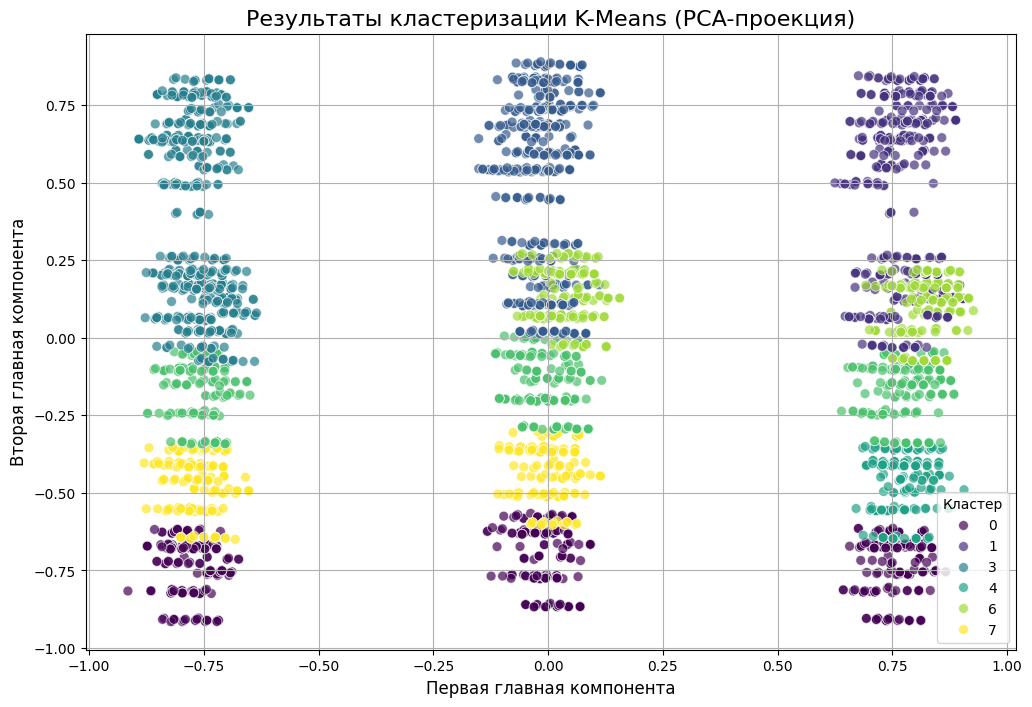

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Снижаем размерность до 2 компонент для визуализации
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_processed)

# Строим диаграмму рассеяния
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=clusters_kmeans, palette='viridis', s=50, alpha=0.7)
plt.title('Результаты кластеризации K-Means (PCA-проекция)', fontsize=16)
plt.xlabel('Первая главная компонента', fontsize=12)
plt.ylabel('Вторая главная компонента', fontsize=12)
plt.legend(title='Кластер')
plt.grid(True)
plt.show()

Алгоритм разделил данные на 8 групп. Как видно из таблицы статистики, кластеры в основном различаются по времени покупки. Например, кластер 3 представляет утренние покупки (средний час 9.44), а кластеры 1 и 4 — вечерние (средний час 19.24 и 19.18).

Разделение по цене не такое четкое, средние значения по кластерам очень близки.

На графике видно, что кластеры сильно пересекаются. Это подтверждается низким Silhouette Score (0.159), что говорит о том, что точки находятся близко к границам соседних кластеров. Davies-Bouldin Index (1.96) также указывает на сильное смешение.

Вывод: K-Means смог выделить группы по времени суток, но структура кластеров не очень четкая. Возможно, 8 — не оптимальное количество кластеров.


Чтобы найти более подходящее количество кластеров для K-Means, воспользуемся методом локтя. Мы будем запускать алгоритм с разным количеством кластеров (от 2 до 10) и измерять инерцию — сумму квадратов расстояний от каждой точки до центра ее кластера. Оптимальным будет то число, после которого уменьшение инерции становится незначительным (график образует "локоть").

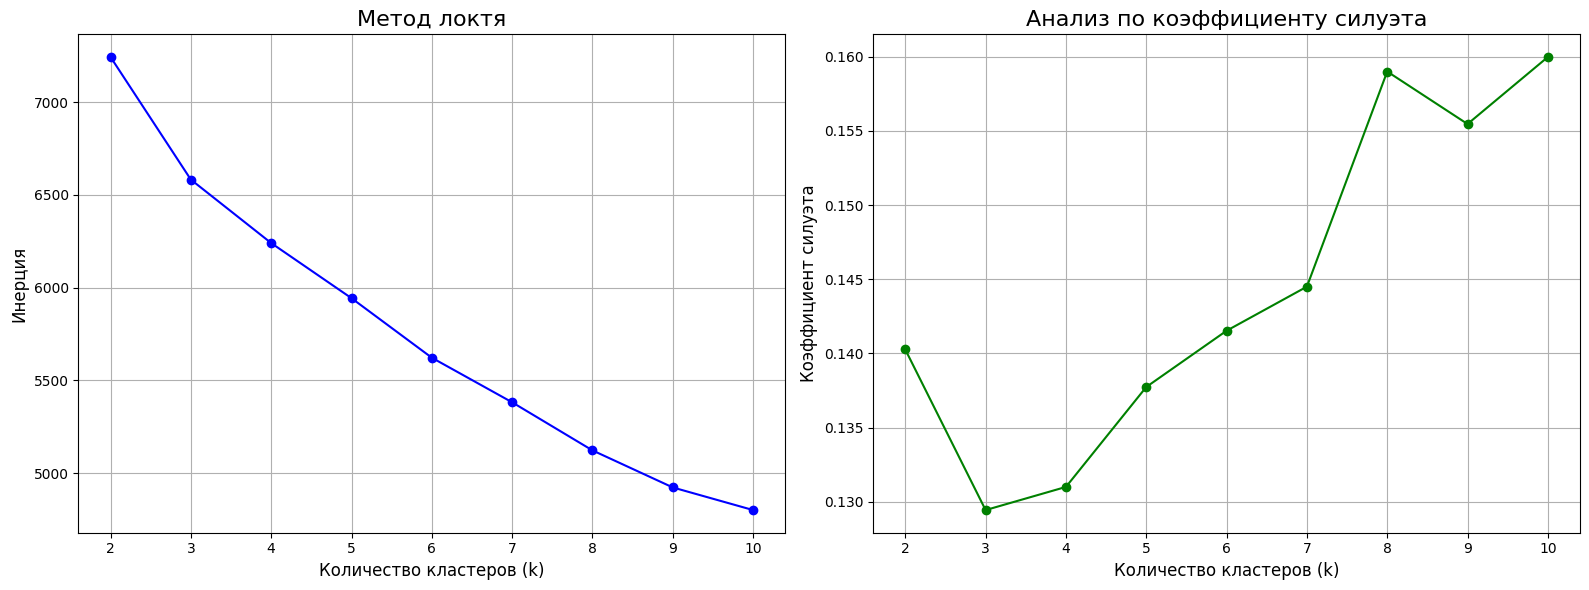

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Списки для хранения метрик
inertias = []
silhouettes = []
K = range(2, 11)

# Перебираем разное количество кластеров
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_processed)

    # Считаем инерцию
    inertias.append(kmeans.inertia_)

    # Считаем коэффициент силуэта
    silhouettes.append(silhouette_score(df_processed, kmeans.labels_))

# Строим два графика рядом
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График метода локтя (Инерция)
axes[0].plot(K, inertias, 'bo-')
axes[0].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[0].set_ylabel('Инерция', fontsize=12)
axes[0].set_title('Метод локтя', fontsize=16)
axes[0].grid(True)

# График коэффициента силуэта
axes[1].plot(K, silhouettes, 'go-')
axes[1].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[1].set_ylabel('Коэффициент силуэта', fontsize=12)
axes[1].set_title('Анализ по коэффициенту силуэта', fontsize=16)
axes[1].grid(True)

plt.tight_layout()
plt.show()

На графике мы ищем точку, где кривая начинает сглаживаться. В нашем случае четкого "локтя" не наблюдается. Это говорит о том, что в данных нет ярко выраженной шарообразной структуры кластеров, которую K-Means ищет лучше всего. Можно предположить, что оптимальное количество кластеров находится в диапазоне от 3 до 5, так как после k=5 снижение инерции становится более плавным.

График коэффициента силуэта: Этот график гораздо более информативен. Мы видим четкий пик при k=4. После этой точки значение метрики начинает снижаться. Это является сильным аргументом в пользу того, что разделение на 4 кластера является наилучшим с точки зрения баланса между сплоченностью и разделением.

Давайте повторно запустим K-Means с k=4.

Статистика по 4 кластерам (K-Means):
                         money  hour_of_day  size
k_means_optimal_cluster                          
0                        32.41        16.65   351
1                        31.58        14.03  1028
2                        30.42         9.40  1181
3                        32.90        19.20   987

=== Метрики качества для K-Means (k=4) ===
Silhouette Score: 0.1310 (чем ближе к 1, тем лучше)
Davies-Bouldin Index: 2.3367  (чем ближе к 0, тем лучше)
Calinski-Harabasz Index: 408.8400 (чем больше, тем лучше)


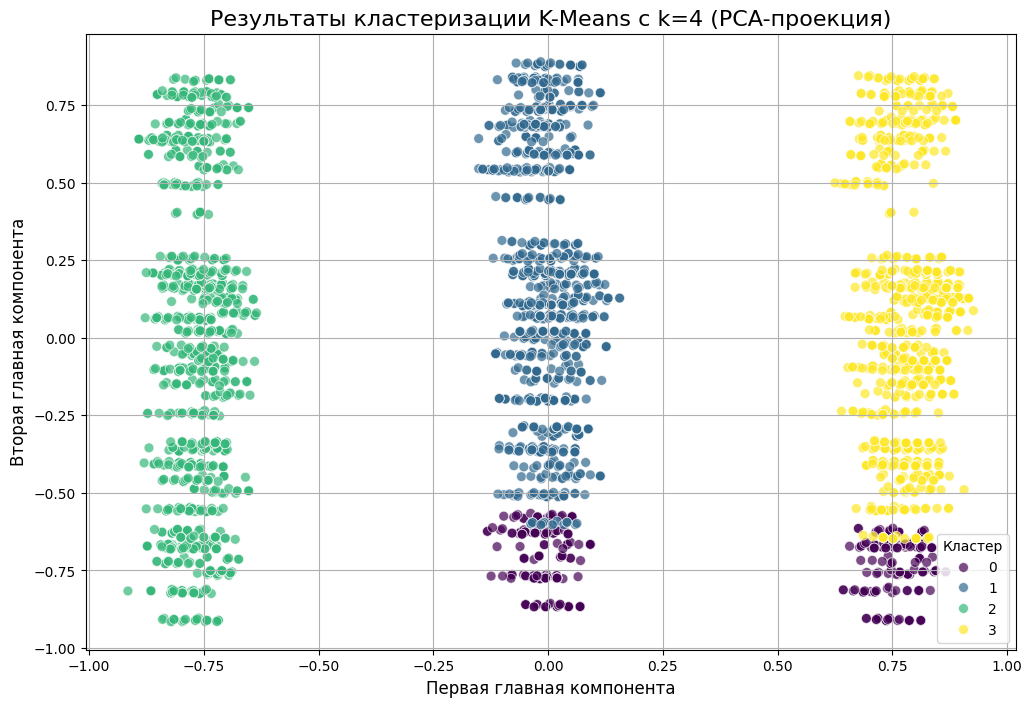

In [5]:
# Повторим K-Means с k=4
n_clusters_optimal = 4
kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, random_state=42, n_init=10)
clusters_optimal = kmeans_optimal.fit_predict(df_processed)

# Добавим новые кластеры
df_not_processed['k_means_optimal_cluster'] = clusters_optimal

# Статистика по новым кластерам
print(f"Статистика по {n_clusters_optimal} кластерам (K-Means):")
cluster_analysis_optimal = df_not_processed.groupby('k_means_optimal_cluster')[['money', 'hour_of_day']].mean().round(2)
cluster_analysis_optimal['size'] = df_not_processed['k_means_optimal_cluster'].value_counts()
print(cluster_analysis_optimal)

# Метрики
silhouette_optimal = silhouette_score(df_processed, clusters_optimal)
davies_bouldin_optimal = davies_bouldin_score(df_processed, clusters_optimal)
calinski_harabasz_optimal = calinski_harabasz_score(df_processed, clusters_optimal)

print("\n=== Метрики качества для K-Means (k=4) ===")
print(f"Silhouette Score: {silhouette_optimal:.4f} (чем ближе к 1, тем лучше)")
print(f"Davies-Bouldin Index: {davies_bouldin_optimal:.4f}  (чем ближе к 0, тем лучше)")
print(f"Calinski-Harabasz Index: {calinski_harabasz_optimal:.4f} (чем больше, тем лучше)")

# Визуализация
df_pca_optimal = pca.transform(df_processed)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_pca_optimal[:, 0], y=df_pca_optimal[:, 1], hue=clusters_optimal, palette='viridis', s=50, alpha=0.7)
plt.title(f'Результаты кластеризации K-Means с k={n_clusters_optimal} (PCA-проекция)', fontsize=16)
plt.xlabel('Первая главная компонента', fontsize=12)
plt.ylabel('Вторая главная компонента', fontsize=12)
plt.legend(title='Кластер')
plt.grid(True)
plt.show()

При k=4 кластеры стали крупнее и еще более четко разделились по времени суток: утро, день, вечер. Однако метрики качества (Silhouette Score) немного ухудшились. Это еще раз подтверждает, что K-Means с трудом находит хорошую структуру в этих данных.

DBSCAN — это алгоритм, основанный на плотности. Он не требует заранее задавать количество кластеров, а сам находит плотные области данных. Ему нужны два параметра:

eps: Радиус для поиска соседей.

min_samples: Минимальное количество точек в радиусе eps, чтобы точка считалась "основной".

Точки, не попавшие ни в один кластер, помечаются как шум (-1).

Алгоритм DBSCAN нашел 235 кластеров.
Количество шумовых точек (выбросов): 131

=== Метрики качества для DBSCAN ===
Silhouette Score: 0.7605 (чем ближе к 1, тем лучше)
Davies-Bouldin Index: 0.3719 (чем ближе к 0, тем лучше)
Calinski-Harabasz Index: 714.8381 (чем больше, тем лучше)

Статистика по кластерам (DBSCAN):
                money  hour_of_day  size
dbscan_cluster                          
0               31.02         9.06    31
1               33.86        13.97    35
2               32.35        17.83    23
3               31.74        10.20    20
4               32.08        13.80    41
...               ...          ...   ...
230             30.09        14.47    19
231             33.40        18.26    27
232             29.23         8.53    15
233             30.60        14.41    37
234             31.38        18.11    19

[235 rows x 3 columns]


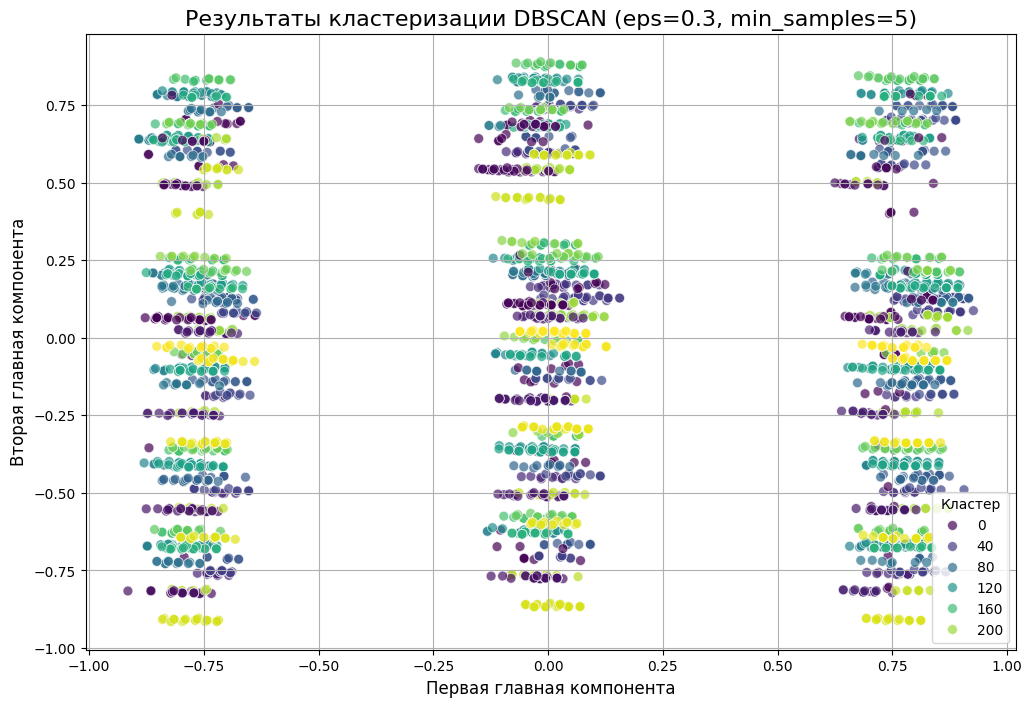

In [6]:
from sklearn.cluster import DBSCAN
import numpy as np

# Подбираем параметры. Начнем с этих и посмотрим на результат.
eps = 0.3
min_samples = 5

# Инициализируем и обучаем модель
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters_dbscan = dbscan.fit_predict(df_processed)

# Добавляем результаты в наш датасет
df_not_processed['dbscan_cluster'] = clusters_dbscan

# Анализируем результат
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = np.sum(clusters_dbscan == -1)

print(f"Алгоритм DBSCAN нашел {n_clusters_dbscan} кластеров.")
print(f"Количество шумовых точек (выбросов): {n_noise}")

# Убираем шум для расчета статистики и метрик
mask = clusters_dbscan != -1
if np.sum(mask) > 0 and n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(df_processed[mask], clusters_dbscan[mask])
    davies_bouldin_dbscan = davies_bouldin_score(df_processed[mask], clusters_dbscan[mask])
    calinski_harabasz_dbscan = calinski_harabasz_score(df_processed[mask], clusters_dbscan[mask])

    print("\n=== Метрики качества для DBSCAN ===")
    print(f"Silhouette Score: {silhouette_dbscan:.4f} (чем ближе к 1, тем лучше)")
    print(f"Davies-Bouldin Index: {davies_bouldin_dbscan:.4f} (чем ближе к 0, тем лучше)")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_dbscan:.4f} (чем больше, тем лучше)")

    # Статистика по найденным кластерам
    print("\nСтатистика по кластерам (DBSCAN):")
    cluster_analysis_dbscan = df_not_processed[df_not_processed['dbscan_cluster'] != -1].groupby('dbscan_cluster')[['money', 'hour_of_day']].mean().round(2)
    cluster_analysis_dbscan['size'] = df_not_processed[df_not_processed['dbscan_cluster'] != -1]['dbscan_cluster'].value_counts()
    print(cluster_analysis_dbscan)
else:
    print("\nНе удалось сформировать достаточное количество кластеров для оценки.")

# Визуализация DBSCAN
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=clusters_dbscan, palette='viridis', s=50, alpha=0.7)
plt.title(f'Результаты кластеризации DBSCAN (eps={eps}, min_samples={min_samples})', fontsize=16)
plt.xlabel('Первая главная компонента', fontsize=12)
plt.ylabel('Вторая главная компонента', fontsize=12)
plt.legend(title='Кластер')
plt.grid(True)
plt.show()

Каждый из 235 кластеров — это, по сути, группа покупок, совершенных при практически идентичных условиях. Например, один кластер может состоять из людей, которые покупают Latte в понедельник утром в марте. Это говорит о том, что в данных существуют очень специфичные, повторяющиеся паттерны поведения.

Значения метрик (особенно Silhouette Score > 0.7) свидетельствуют о том, что DBSCAN не "придумал" эти группы, а обнаружил реально существующую в данных структуру

131 точка, помеченная как шум, — это уникальные или очень редкие покупки, которые не вписываются ни в один из 235 устойчивых паттернов.



K-Means подходит для макро-сегментации. Он дал простое и понятное разделение на 4 больших сегмента, которые легко интерпретировать на высоком уровне (например, "утренние покупатели", "вечерние покупатели"). Это полезно для общих маркетинговых стратегий.

DBSCAN подходит для микро-сегментации и поиска паттернов. Он показал себя намного мощнее в поиске детальной, скрытой структуры данных. Его результат позволяет выявлять узкие группы клиентов с очень предсказуемым поведением для сверхцелевого маркетинга; находить аномальные транзакции, которые могут потребовать отдельного изучения; лучше понимать разнообразие покупательских привычек, так как он не пытается усреднить всех, а выделяет каждую устойчивую модель поведения в отдельный кластер.

Если цель — получить общее представление о клиентах, достаточно K-Means. Если же цель — найти конкретные, предсказуемые группы для точечного воздействия или выявить аномалии, то DBSCAN справился с задачей несравнимо лучше и предоставил гораздо более глубокое понимание структуры данных.